# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [28]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

#Import of preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
import spacy
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [30]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [ ]:
df_reviews = pd.read_csv('C:/Users/david/1.Archivos-Directorios/Python/Tripleten/Sprint 16/Datos/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.info()
print("Importación de datos completada. Hay un par de registros con valores nulos en average_rating y votes.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [32]:
#Duplicados 
print(df_reviews.duplicated().sum(), "\nSin Duplicados")

#Remoción de nulos
df_reviews.dropna(inplace=True)
print("Registros con valores nulos removidos. 2 registros eliminados.")

display(df_reviews.describe())
print("Equilibrio de datos adecuado ambos cernaos a 50%, los negativos son ligeramente menos con un 49.89% de representación.")
print("\nCantidades de revies negativos y positivos:", df_reviews["pos"].value_counts(), "\nHay 101 revisiones positivas adicionales al número de negativos.")

0 
Sin Duplicados
Registros con valores nulos removidos. 2 registros eliminados.


,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000000,47329.000000,47329.000000,4.732900e+04,47329.000000,47329.000000,47329.000000
mean,1989.630882,0.001733,5.998278,2.556292e+04,5.484439,0.498933,6279.826808
std,19.600702,0.041588,1.494289,8.367004e+04,3.473083,0.500004,3605.724280
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6300.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


Equilibrio de datos adecuado ambos cernaos a 50%, los negativos son ligeramente menos con un 49.89% de representación.

Cantidades de revies negativos y positivos: 0    23715
1    23614
Name: pos, dtype: int64 
Hay 101 revisiones positivas adicionales al número de negativos.


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

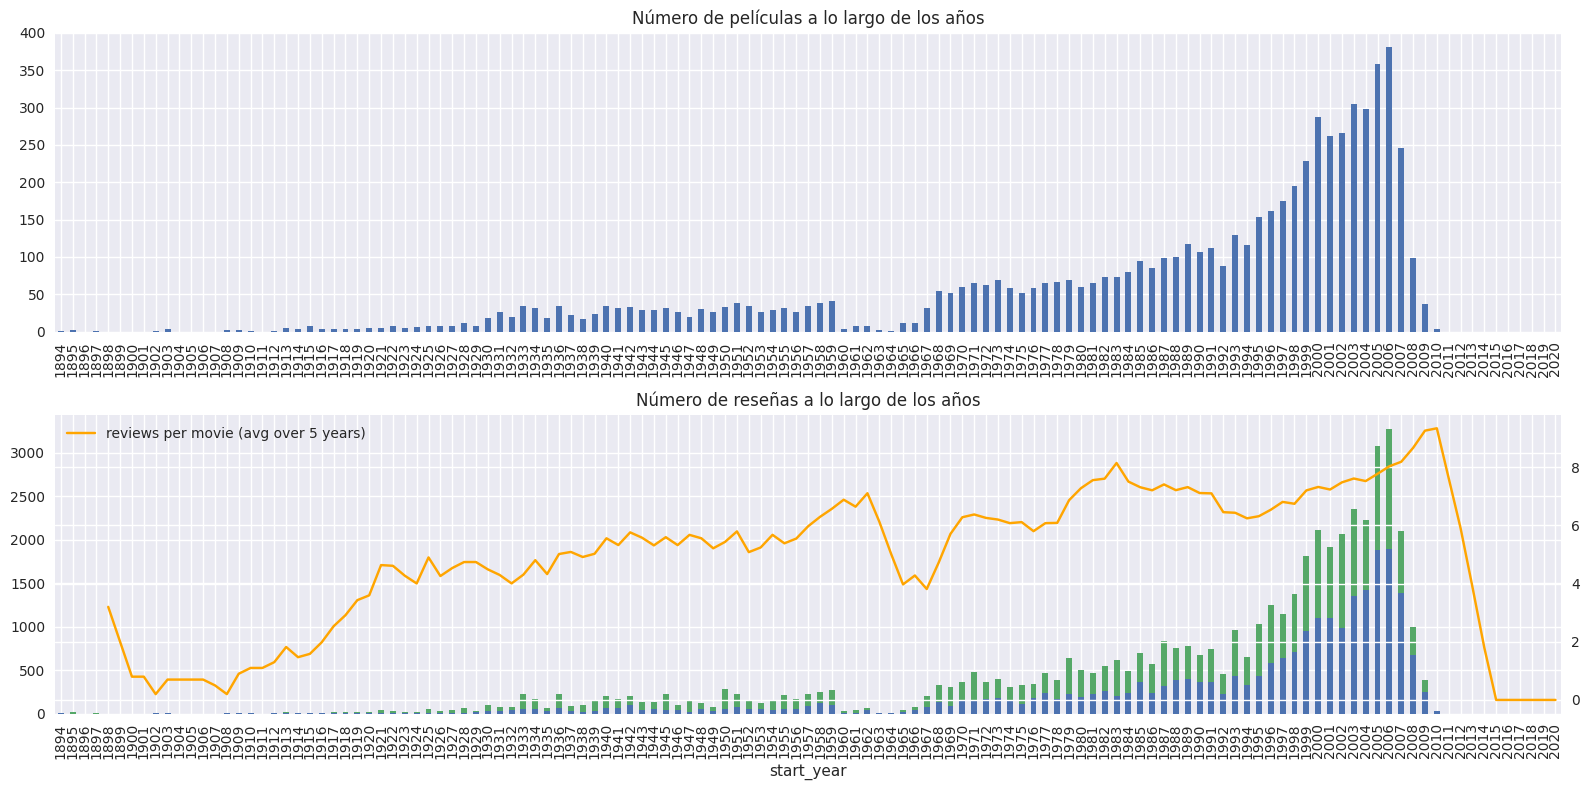

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

La mayoría de reseñas recibidas por película son de 1 a 5.


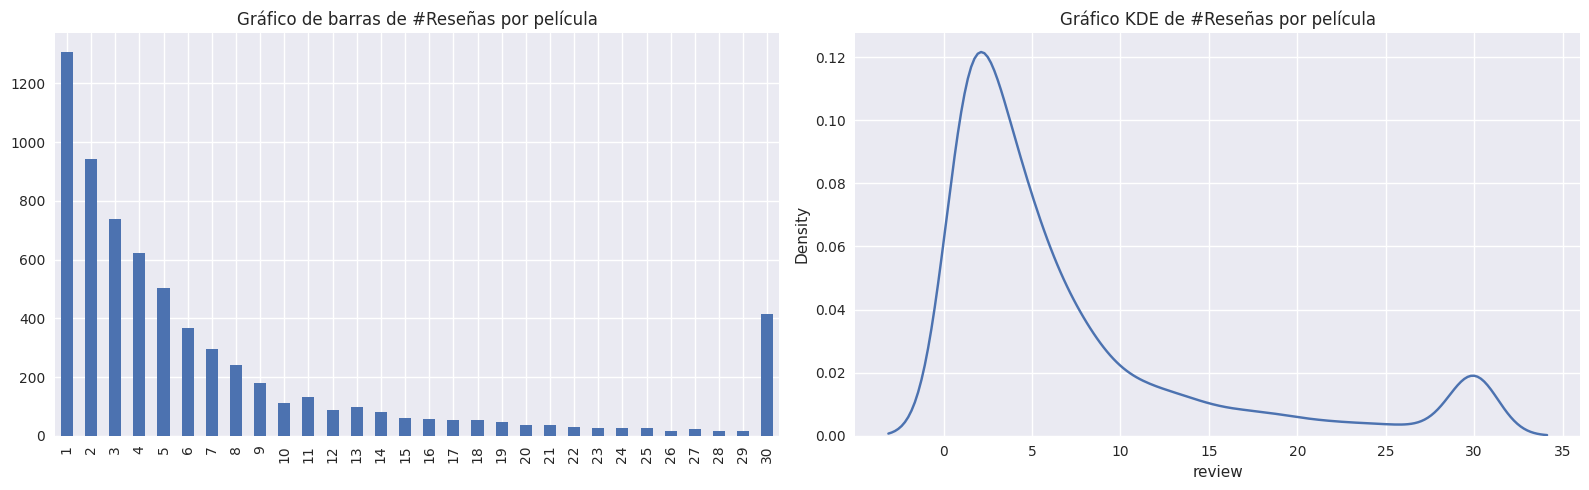

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()
print("La mayoría de reseñas recibidas por película son de 1 a 5.")

El patrón de puntuaciones está ampliamente conservado entre el set de datos de entrenamiento y de prueba.


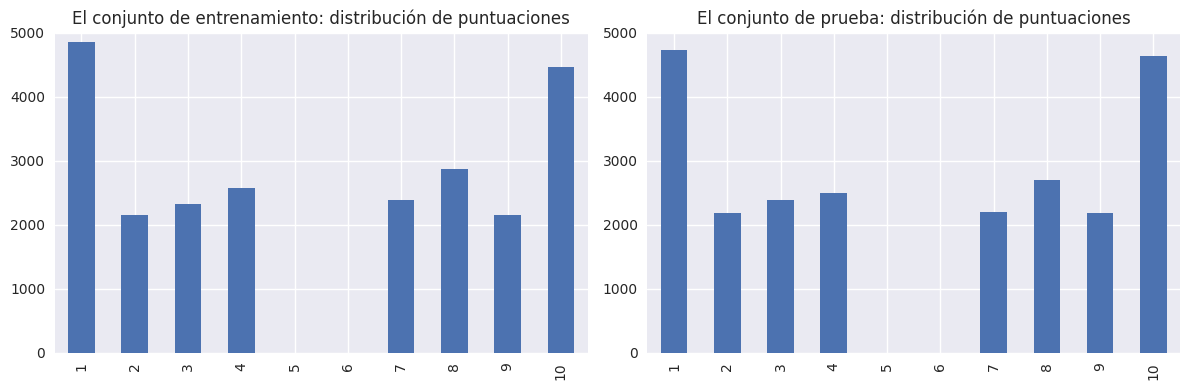

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()
print("El patrón de puntuaciones está ampliamente conservado entre el set de datos de entrenamiento y de prueba.")

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


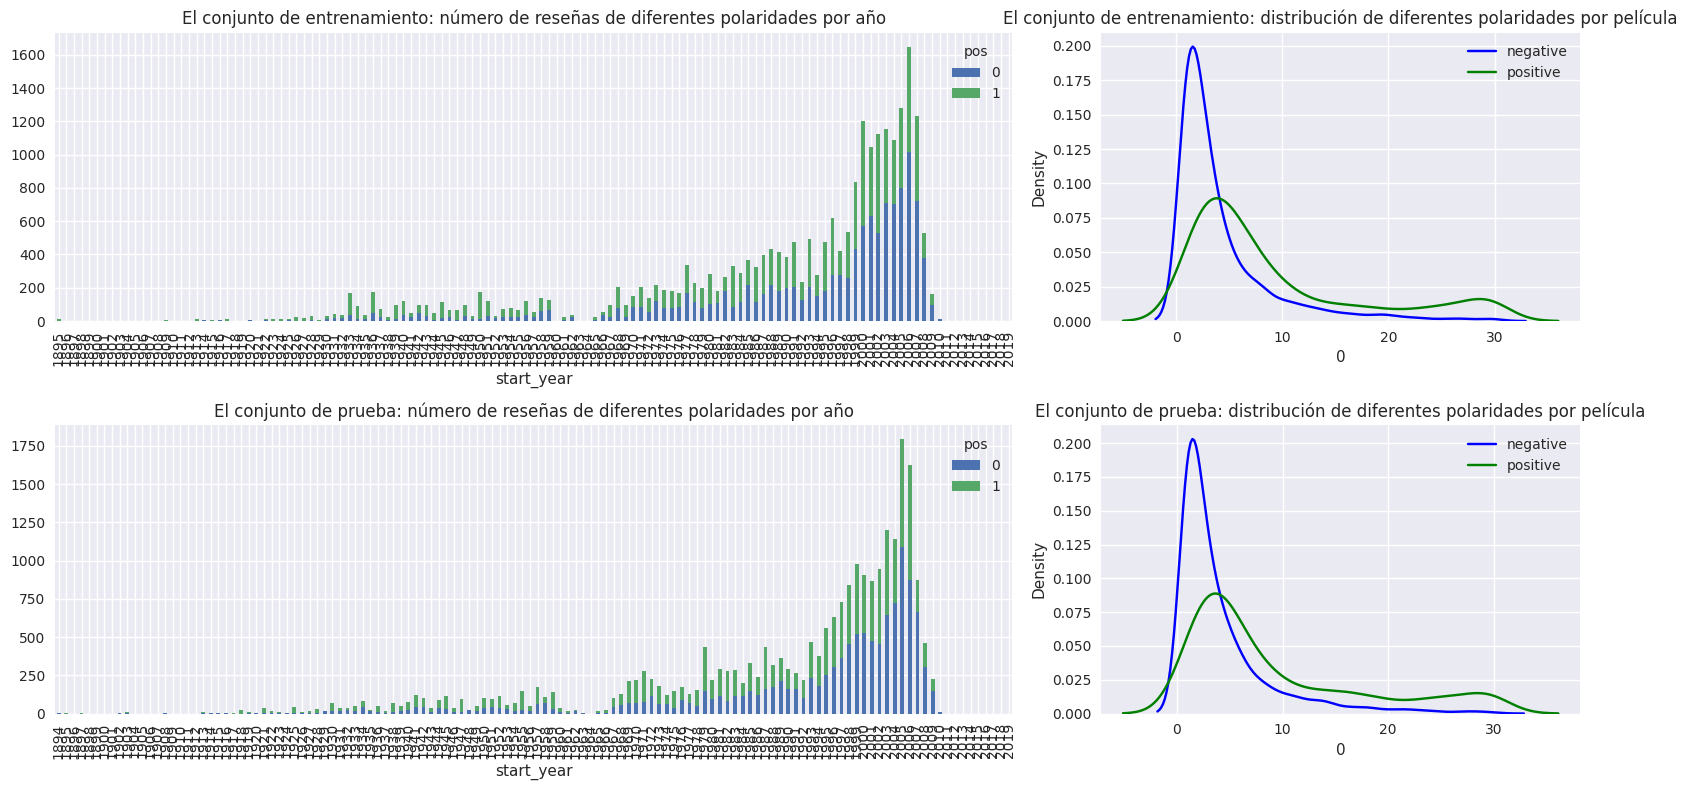

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [37]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [38]:
#Función de limpieza 
def clean_text(text):
    # Convierte a minúsculas
    text = text.lower()
    
    # Elimina todo lo que no sean letras ni apóstrofes
    text = re.sub(r"[^a-z\s']", ' ', text)
    
    # Elimina espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text



df_reviews['review_norm'] = df_reviews["review"].apply(clean_text)
#Revisar el formato 
print(df_reviews["review_norm"].head(2))
print("El formato se ve acorde en minúsculas y sin puntuaciones salvo que a veces se pueden encontrar algunos espacios extra.")

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
Name: review_norm, dtype: object
El formato se ve acorde en minúsculas y sin puntuaciones salvo que a veces se pueden encontrar algunos espacios extra.


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [39]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [40]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

train_features = df_reviews_train["review_norm"]
test_features = df_reviews_test["review_norm"]

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [41]:
#Vectorización TF-IDF
stop_words = stopwords.words("english")
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000, min_df=5)
X_train_vect = vectorizer.fit_transform(train_features)
X_test_vect = vectorizer.fit_transform(test_features)

#Importe de embeddings o codificaciones semánticas para modelos. (se evita proceso computacionalmente robusto: hecho en local)

In [ ]:
#Importe de embeddings
train_embeddings = np.load("C:\Users\david\1.Archivos-Directorios\Python\Tripleten\Sprint 16\Datos\test_embeddings_scaled.npz")["train"] #cambiar las rutas conforme sea necesario
test_embeddings = np.load("C:\Users\david\1.Archivos-Directorios\Python\Tripleten\Sprint 16\Datos\test_embeddings_scaled.npz")["test"]

#Generación de las variables objetivo
train_embed_target_sample, _ = train_test_split(train_target, train_size=0.10, random_state=54321)
test_embed_target_sample, _ = train_test_split(test_target, train_size=0.10, random_state=54321)

## Trabajar con modelos

### Modelo 0 - Constante

In [43]:
#Iniciar el modelo dummy
dummy = DummyClassifier(strategy="most_frequent", random_state=54321)
#Entrenar 
dummy.fit(X_train_vect, train_target)

DummyClassifier(random_state=54321, strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
El modelo no identifica verdaderos positivos porque fue entrenado para mencionar lo más frecuente que en entrenamiento fueron los valores negativos.
0    11912
1    11884
Name: pos, dtype: int64


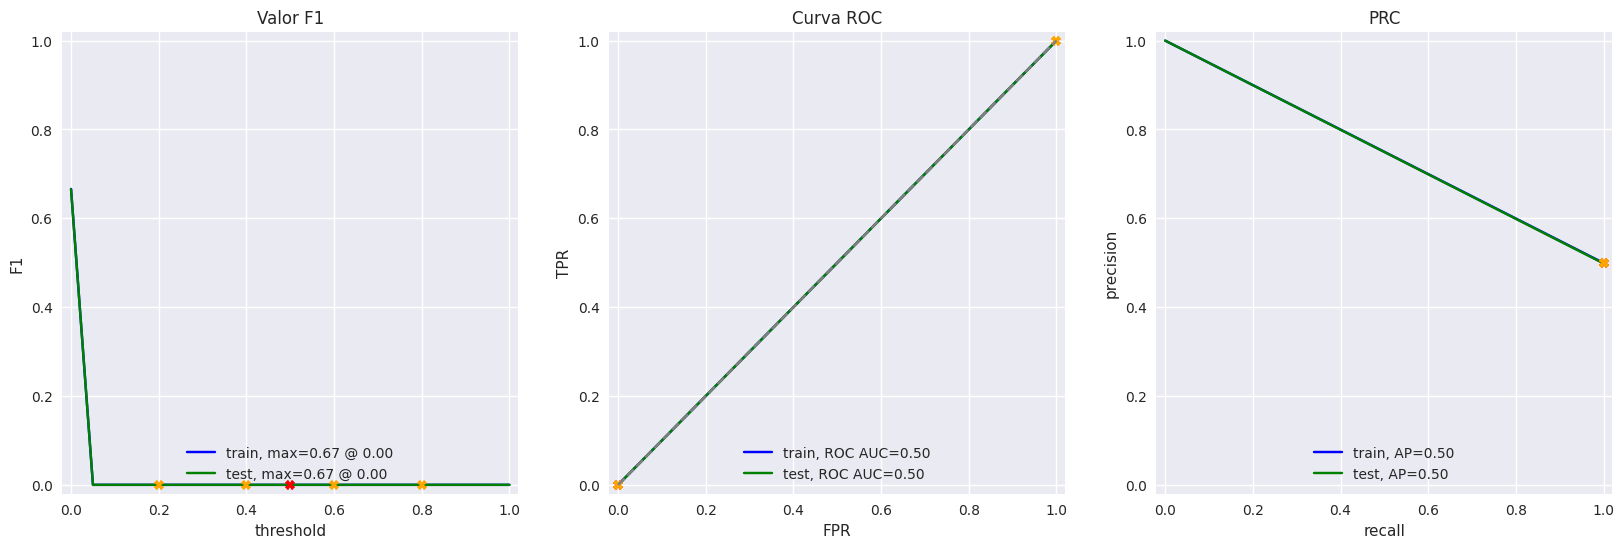

In [44]:
#Evaluar modelo dummy
evaluate_model(dummy, X_train_vect, train_target, X_test_vect, test_target)
print("El modelo no identifica verdaderos positivos porque fue entrenado para mencionar lo más frecuente que en entrenamiento fueron los valores negativos.")
#Evidencia
print(train_target.value_counts())

#Modelo 1 - LR - Regresión logística con vectores. 

In [45]:
#Modelo 1 - LR - Regresión logística con vectores. 
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=54321)
lr.fit(X_train_vect, train_target)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=54321)

          train  test
Accuracy   0.91  0.60
F1         0.91  0.60
APS        0.97  0.63
ROC AUC    0.97  0.65
Discriminación de valores en set de entrenamiento F1 = 93% pero en entrenamiento solo el 60% lo cual es menor al objetivo de 85% de asertividad en distinguir positivos y negativos. 


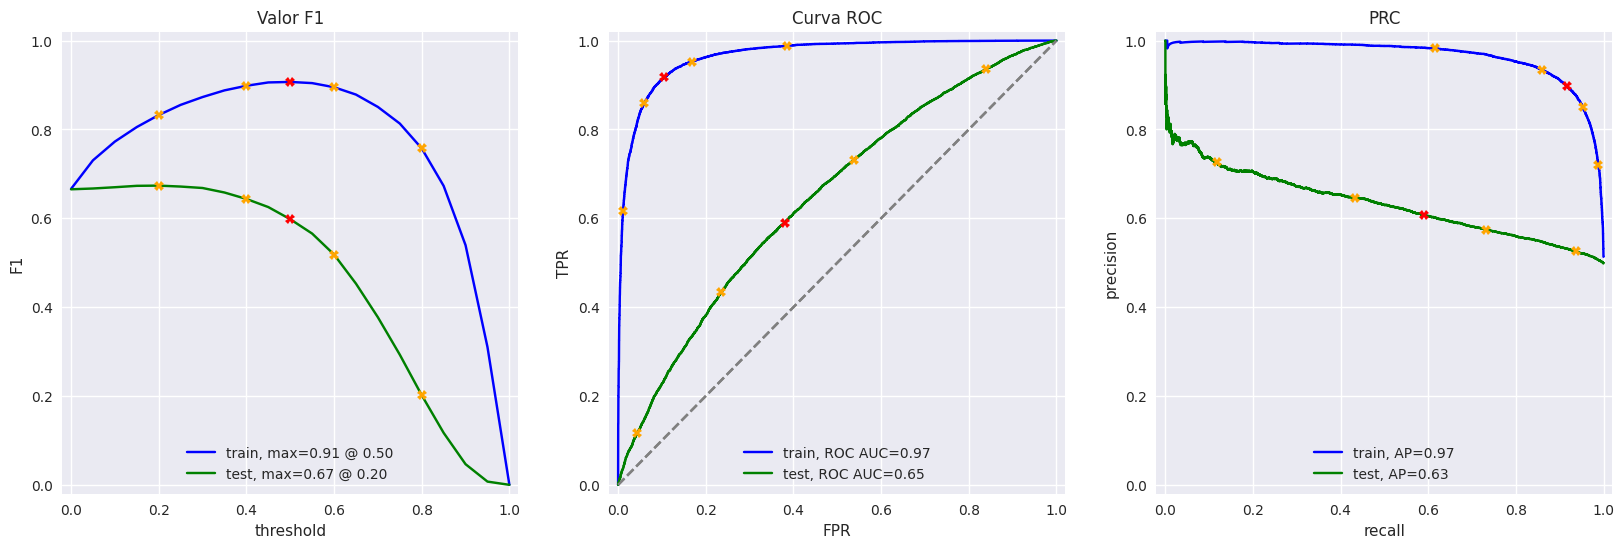

In [46]:
#Evaluar el modelo LR
evaluate_model(lr, X_train_vect, train_target, X_test_vect, test_target)

print("Discriminación de valores en set de entrenamiento F1 = 93% pero en entrenamiento solo el 60% lo cual es menor al objetivo de 85% de asertividad en distinguir positivos y negativos. ")

Modelos fundamentados en lematización spacy. 

Nota: Tomaron mucho tiempo y recursos sin dar buenos resultados. Se comentó el código en local y no fue reportado por este medio. 

#LGBM sobre vectorización de textos

In [47]:
#Muestreo para emplear menos recursos computacionales en la búsqueda de hiperparámetros
x_train_vect_sample, _, y_train_sample, _ = train_test_split(X_train_vect, train_target, train_size = 0.4, random_state = 54321)
print(x_train_vect_sample.shape)
#Búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.1],
    'num_leaves': [50, 100]
}

lgbm = LGBMClassifier(random_state=42)

grid_lgbm = GridSearchCV(
    lgbm, param_grid,
    scoring='f1',
    cv=2,
    n_jobs=-1,
    verbose=1
)
grid_lgbm.fit(x_train_vect_sample, y_train_sample)
print("Mejor F1 en validación:", grid_lgbm.best_score_)
print("Mejores parámetros:", grid_lgbm.best_params_)

y_pred_lgbm = grid_lgbm.predict(X_test_vect)
print("F1 Test:", f1_score(test_target, y_pred_lgbm))
print("Accuracy Test:", accuracy_score(test_target, y_pred_lgbm))

print("F1 es bastante bajo, lgbm con el preprocesado convencional no entiende contextos de las palabras. F1 = 57%")

(9518, 3000)
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Mejor F1 en validación: 0.8461982094710467
Mejores parámetros: {'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 50}
F1 Test: 0.574346440885087
Accuracy Test: 0.5855607019929461
F1 es bastante bajo, lgbm con el preprocesado convencional no entiende contextos de las palabras. F1 = 57%


Modelo 4-Procesamiento contextual con embeddings + LR o lgbm

          train  test
Accuracy   0.88  0.87
F1         0.88  0.87
APS        0.96  0.93
ROC AUC    0.95  0.94
Usando embeddings el modelo mejoró aún con el uso de una cantidad mínima de datos. Se usará lgbm con embeddings. F1 = 88% > 85%, el modelo ya está sobre el umbral de aceptación de distinguir sentimientos a partir de palabras.


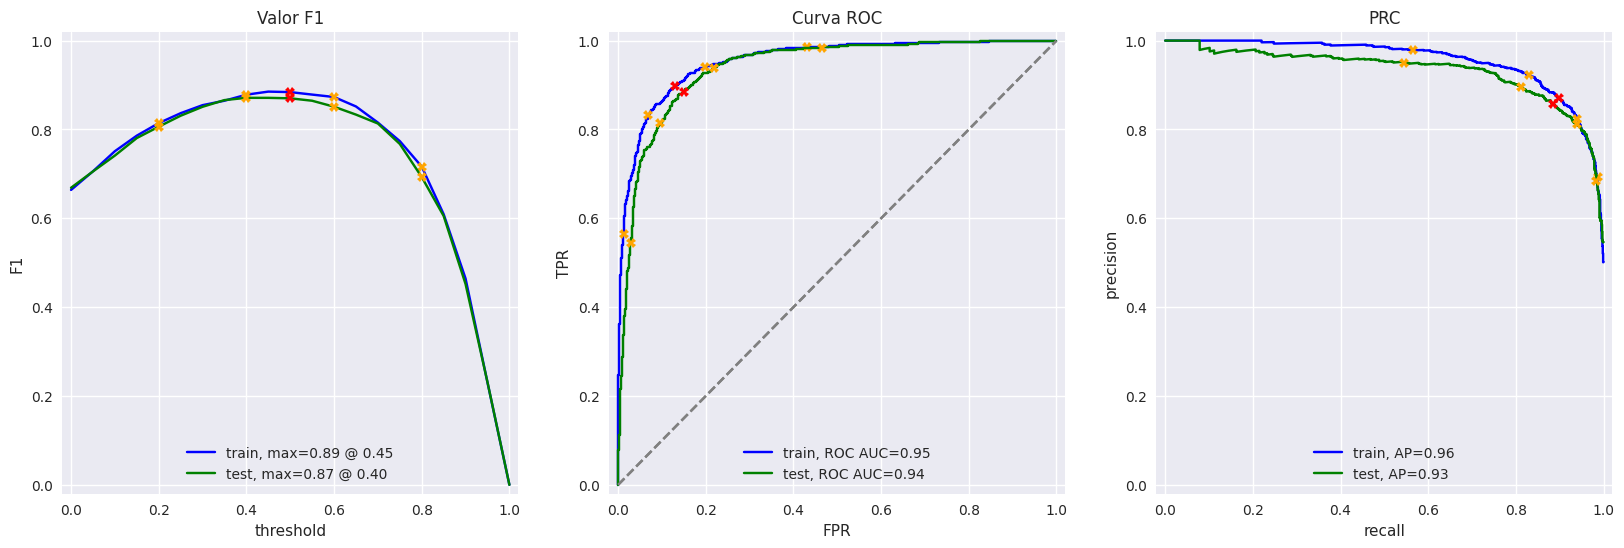

In [60]:
#Modelo LR +embeddings. 
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=54321)
clf.fit(train_embeddings, train_embed_target_sample)

#Evaluar el modelo 
evaluate_model(clf, train_embeddings, train_embed_target_sample, test_embeddings, test_embed_target_sample) #Nota: los objetivos o target no son embed se usó ese nombre para generar similitud de variables.
print("Usando embeddings el modelo mejoró aún con el uso de una cantidad mínima de datos. Se usará lgbm con embeddings. F1 = 88% > 85%, el modelo ya está sobre el umbral de aceptación de distinguir sentimientos a partir de palabras.")

Fitting 2 folds for each of 4 candidates, totalling 8 fits
          train  test
Accuracy    1.0  0.85
F1          1.0  0.86
APS         1.0  0.92
ROC AUC     1.0  0.93


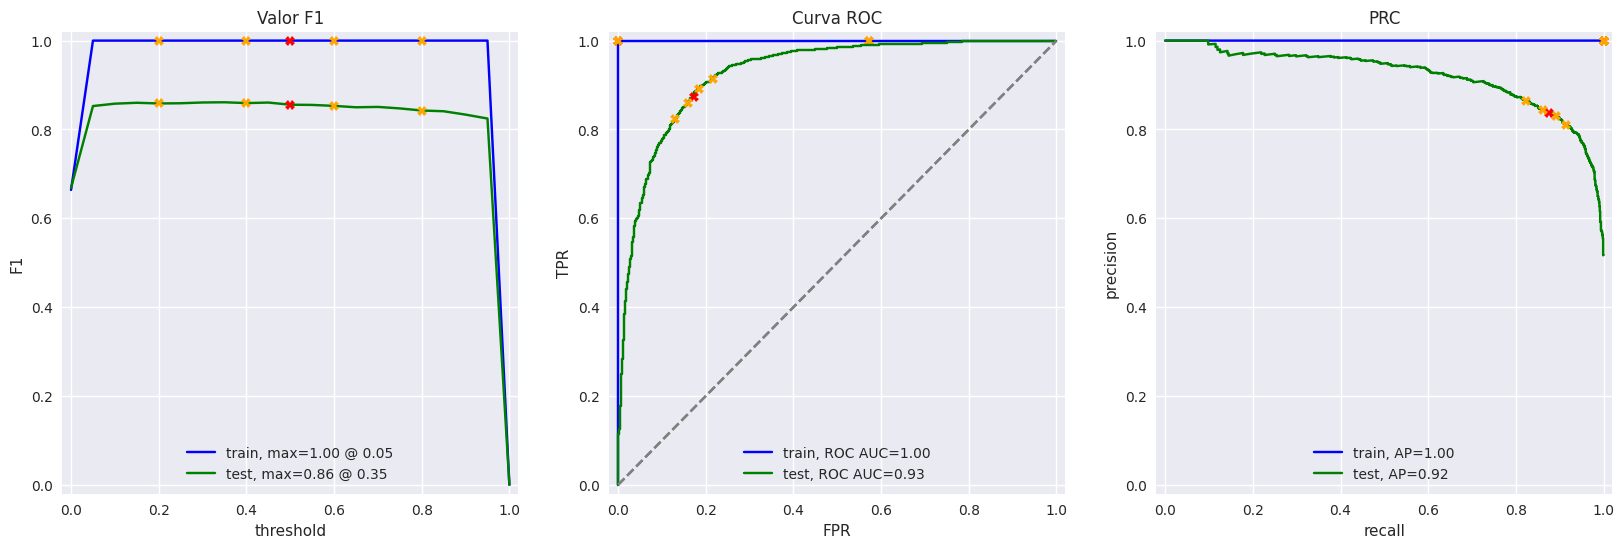

In [61]:
#Modelo lgbm
param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.1],
    'num_leaves': [50, 100]
}

lgbm = LGBMClassifier(random_state=54321)

grid_lgbm_embed = GridSearchCV(
    lgbm, param_grid,
    scoring='f1',
    cv=2,
    n_jobs=-1,
    verbose=1
)

grid_lgbm_embed.fit(train_embeddings, train_embed_target_sample)
#Mejor modelo 
grid_lgbm_embed_hiperparameter_tunned = grid_lgbm_embed.best_estimator_
grid_lbgm_embed = grid_lgbm_embed_hiperparameter_tunned
#Evaluate model 
evaluate_model(grid_lgbm_embed_hiperparameter_tunned, train_embeddings, train_embed_target_sample, test_embeddings, test_embed_target_sample)

## Mis reseñas

In [62]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews["review"].apply(clean_text)

#Importar el embedding
my_reviews_embed = np.load("my_reviews.npz")["valid"]

### Modelo 1

In [63]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = lr.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
print("Los números son probabilidades de que la reseña sea positiva.")

0.39:  i did not simply like it not my kind of movie
0.72:  well i was bored and felt asleep in the middle of the movie
0.38:  i was really fascinated with the movie
0.24:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.28:  i didn't expect the reboot to be so good writers really cared about the source material
0.56:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.69:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.69:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo
Los números son probabilidades de que la reseña sea positiva.


### Modelo 2

In [64]:
texts = my_reviews['review_norm']
lgbm.fit(X_train_vect, train_target)
my_reviews_pred_prob = lgbm.predict_proba(vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.68:  i did not simply like it not my kind of movie
0.65:  well i was bored and felt asleep in the middle of the movie
0.68:  i was really fascinated with the movie
0.50:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.70:  i didn't expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.67:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.72:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3 -LR con embeddings

In [65]:

my_reviews_pred_prob = clf.predict_proba(my_reviews_embed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.54:  i did not simply like it not my kind of movie
0.10:  well i was bored and felt asleep in the middle of the movie
0.85:  i was really fascinated with the movie
0.02:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.60:  i didn't expect the reboot to be so good writers really cared about the source material
0.93:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.06:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.97:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3 -Lgbm con embeddings

In [66]:
my_reviews_pred_prob = grid_lgbm_embed.predict_proba(my_reviews_embed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.96:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
1.00:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.99:  i didn't expect the reboot to be so good writers really cared about the source material
1.00:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusiones

Se revisaron multiples modelos. 
Control, regresión lineal y ML lgbm con vectores 
y regresión lineal y lgbm con consideración semántica o embeddings. 

Se llegó a un 88% de discriminación entre sentimientos positivos y negativos en reseñas por modelo de regresión lineal y 87% por lgbm. Sin embargo lgbm al probarlo con las reseñas de validación fue mucho más preciso con lo esperado (sección 8; 8.3 vs 8.4.).

Se cumplió con el umbral de aceptación F1 = 87% y 88% > 85%. 

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones